In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import asymNdimPdf as apdf

In [29]:
import matplotlib as mpl
mpl.rcParams['legend.frameon']  = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize']  = 18
mpl.rcParams['axes.labelsize']  = 18
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['figure.figsize']  = (10, 7)

In [30]:
cov = np.array([
    [ 1.0000, -0.1949,  0.2583, -0.3933],
    [-0.1949,  1.0000, -0.1188,  0.2919],
    [ 0.2583, -0.1188,  1.0000, -0.3443],
    [-0.3933,  0.2919, -0.3443,  1.0000],
])

In [31]:
measList = np.array([
    [294288603.77097332, 29726222.606283784, -23672504.108643234],
    [1422822752.7824574, 34181144.593426704, -33513316.302916765],
    [1267256904.8604925, 34413027.555306196, -32740743.069167614],
    [189913774.63168541, 17348726.511133254, -19868612.427323759],
])
measList = np.abs(measList) * 1e-6

print(measList)

[[ 294.28860377   29.72622261   23.67250411]
 [1422.82275278   34.18114459   33.5133163 ]
 [1267.25690486   34.41302756   32.74074307]
 [ 189.91377463   17.34872651   19.86861243]]


In [32]:
snParams = []
for m in measList:
    snParams.append(apdf.paramFromMeas(m[0], m[2], m[1]))               

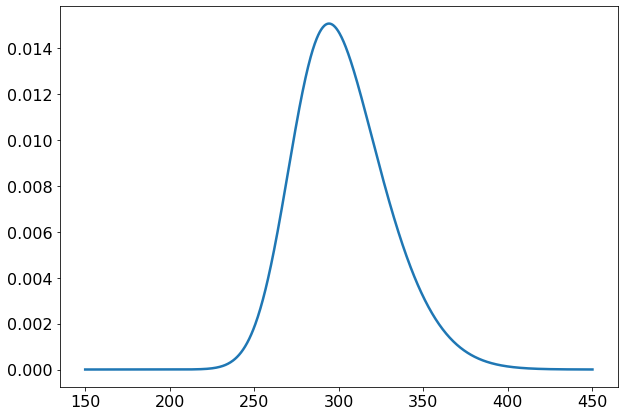

In [33]:
# Example of 1D PDF for the 1st bin
x = np.linspace(150, 450, 1000)
l, s, a = snParams[0]
plt.plot(x, apdf.ndimSkewNormal(loc=l, scale=s, alpha=a).pdf(x));

In [34]:
# N-dim PDF
loc, scale, alpha = [], [], []
for p in snParams:
    loc.append(p[0])
    scale.append(p[1])
    alpha.append(p[2])

ndSN = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=cov, alpha=alpha)
ndSNnoCorr = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=np.diag((1, 1, 1, 1)), alpha=alpha)

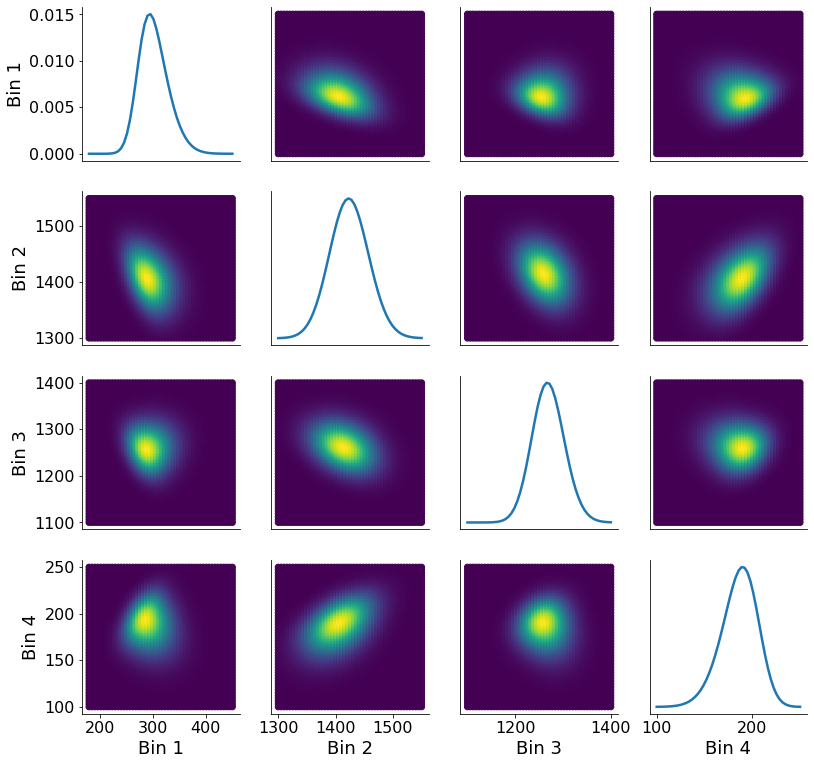

In [35]:
ndSN.plot(borders=[[180,450], [1300, 1550], [1100, 1400], [100, 250]],
         varNames=['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4'], contour=False)

In [36]:
toys = apdf.generateData(ndSN.pdf, n=9000000, borders=[[150, 400], [1300, 1500], [1100, 1400], [100, 250]])

In [37]:
toys.shape

(122010, 4)

[2.118811881188119, 0.7038703870387018, 0.9378937893789364, -1.6651665166516665]


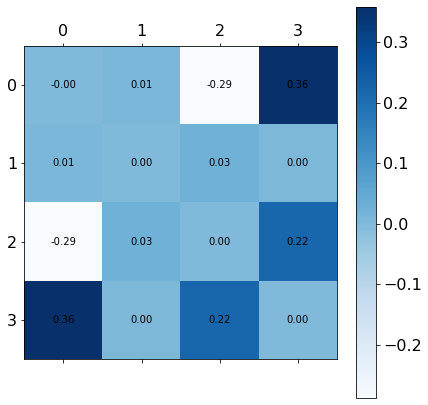

In [48]:
outputCov = np.corrcoef(toys.T)
diff = (outputCov - cov)

plt.matshow(diff, cmap='Blues')
plt.colorbar()

print(alpha)

for i in range(diff.shape[0]):
    for j in range(diff.shape[0]):
        c = diff[j,i]
        plt.text(i, j, '{:.2f}'.format(c), va='center', ha='center');

In [313]:
%timeit data=getToysGaussian(9000000)
print(data.shape[0] /9000000. * 100 )

4.84 s ± 331 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.123144444444445


In [314]:
%timeit toys = apdf.generateData(ndSN.pdf, n=9000000, xLim=[[150, 400], [1300, 1500], [1100, 1400], [100, 250]])
print(toys.shape[0] /9000000. * 100 )

3.46 s ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.3570555555555557


In [232]:
def getBorders(sn):
    borders = []
    for i in range(sn.dim):
        loc, scale, alpha = sn.loc[i], sn.scale[i, i], sn.alpha[i]
        sn_tmp = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
        v, m, p = sn_tmp.measAsymError()
        borders.append([v-3*m, v+3*p])
    return np.array(borders)

In [234]:
borders = getBorders(ndSN)

def getPar():
    for m in measList:
        loc, scale, alpha = apdf.paramFromMeas(*m)

In [235]:
%timeit getPar()

37.7 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [237]:
%timeit getBorders(ndSN)

710 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [187]:
def getNtoys(pdf, nMin, borders, chunck=100000):
    nToys, data = 0, []
    while nToys<nMin:
        data.append(apdf.generateData(pdf, n=chunck, xLim=borders))
        nToys += data[-1].shape[0]
    return np.concatenate(data)

toys = getNtoys(ndSN.pdf, nMin=5000, borders=borders)
print(toys.shape)

(7948, 4)


In [188]:
loc, scale, alpha = [], [], []
for p in snParams + snParams:
    loc.append(p[0])
    scale.append(p[1])
    alpha.append(p[2])
cov2 = np.diag([1]*8)
#print(cov2)
ndSN2 = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=cov2, alpha=alpha)

In [190]:
borders2 = getBorders(ndSN2)
print(borders2.shape)

(8, 2)


In [ ]:
def testNdimForGeneration(ndim):
    loc = [0]*ndim
    scale=[1]*ndim 
    cov=np.diag([1]*ndim)
    ndsn = apdf.ndimSkewNormal(loc=loc, scale=scale, cov=cov, alpha=loc)
    return getNtoys(ndsn.pdf, nMin=200000, borders=[[-3, 3]]*ndim)

In [214]:
#%timeit testNdimForGeneration(1)

69.2 ms ± 588 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [215]:
#%timeit testNdimForGeneration(2)

277 ms ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [216]:
#%timeit testNdimForGeneration(5)

4.64 s ± 92.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [217]:
#%timeit testNdimForGeneration(10)

2min 34s ± 2.47 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [315]:
toys = getToysGaussian(9000000)
w = np.array([-0.75, -0.25, 0.25, 0.75])
Ckk = -9 * np.sum(toys*w, axis=1) / np.sum(toys, axis=1)

In [316]:
from scipy.stats import skewnorm
alpha, loc, scale = skewnorm.fit(Ckk)

(0.3194332785080804, 0.06733544764531234, 0.07286705797234758)


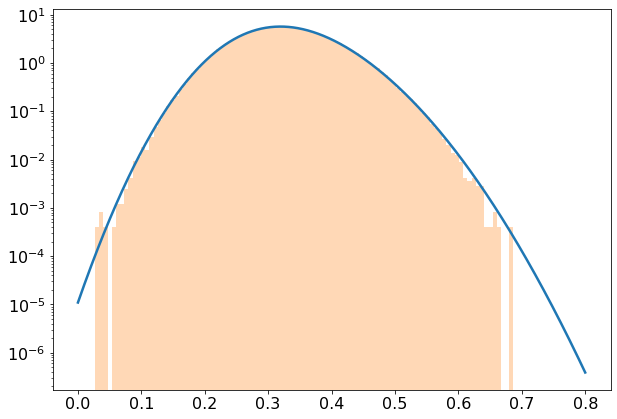

In [317]:
sn = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
x=np.linspace(0, 0.8, 1000)
plt.plot(x, sn.pdf(x))
plt.hist(Ckk, bins=100, density=True, alpha=0.3, log=True);
print(sn.measAsymError())

In [15]:
toys = apdf.generateData(ndSNnoCorr.pdf, n=9000000, xLim=[[150, 400], [1300, 1500], [1100, 1400], [100, 250]])

(0.32131684705118235, 0.08067275189980683, 0.08691924175036844)


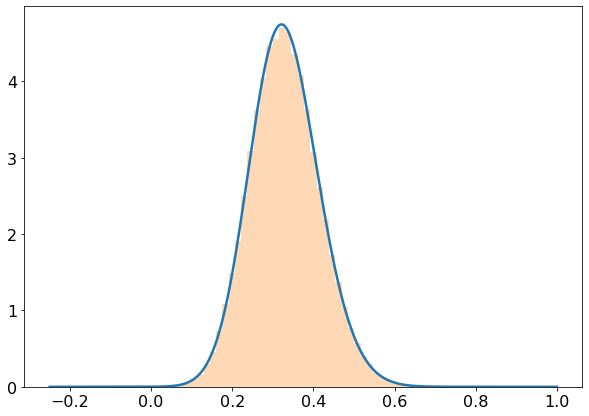

In [16]:
w = np.array([-0.75, -0.25, 0.25, 0.75])
Ckk = -9 * np.sum(toys*w, axis=1) / np.sum(toys, axis=1)
alpha, loc, scale = skewnorm.fit(Ckk)
sn = apdf.ndimSkewNormal(loc=loc, scale=scale, alpha=alpha)
x=np.linspace(-0.25, 1.0, 1000)
plt.plot(x, sn.pdf(x))
plt.hist(Ckk, bins=50, density=True, alpha=0.3);
print(sn.measAsymError())